<a href="https://colab.research.google.com/github/blufzzz/Dynamic-Texture-3D-CNN/blob/master/3D_CNN_Video_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is demo for dynamic texture synthesis via auto-regresion of the frame sequence

In [0]:
import urllib
import requests
from os import path
# нужна информация о нашей системе
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

# уточним на чем будем вычислять
accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x570e6000 @  0x7ff0155a72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.


In [0]:
!pip install --no-cache-dir -I pillow

    100% |████████████████████████████████| 2.0MB 65.5MB/s 
fastai 1.0.41 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
from skimage import io
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.core.display import clear_output
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [60]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd ./gdrive/My\ Drive/Colab Notebooks/two-stream-dyntex-synth

/content/gdrive/My Drive/Colab Notebooks/two-stream-dyntex-synth


In [0]:
class SimpleCNN3D(nn.Module):
  
  def __init__(self):
    
    super(SimpleCNN3D, self).__init__()
    
    self.conv1 = nn.Conv3d(3,32, (3,3,3), stride=1, padding=(0,1,1), bias=True)
    self.pool1 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.conv2 = nn.Conv3d(32, 64, (3,3,3), stride=1, padding=(0,1,1), bias=True)
    self.pool2 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.conv3 = nn.Conv3d(64, 72, (2,3,3), stride=1, padding=(0,1,1), bias=True)
    self.pool3 = nn.MaxPool3d((1,2,2), stride = (1,2,2))

    self.unconv1 = nn.ConvTranspose2d(72,64, (2,2), stride = 2, bias=True)
    self.unconv2 = nn.ConvTranspose2d(64,32, (2,2), stride = 2, bias=True)
    self.unconv3 = nn.ConvTranspose2d(32,3, (2,2), stride = 2, bias=True)
        
  def forward(self, x):

    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    x = self.pool3(x)
    x = x.reshape(1,x.shape[1], x.shape[-1], x.shape[-1])
    x = self.unconv1(x)
    x = self.unconv2(x)
    x = self.unconv3(x)
    
    return x
  

In [0]:
fold = './data/dynamic_textures/fur/'

def get_seq(fold, seq_len):
  
  names = sorted(os.listdir(fold))[:12] # HARDCODED
  
  n_framesets = len(names) - seq_len + 1
  
  for i in range(n_framesets - 1):
  
    imgs = []
    
    y = io.imread(os.path.join(fold, names[i+seq_len])).transpose(2,0,1)
   
    y = np.expand_dims(y,0)
    
    for name in names[i:i+seq_len]:
  
      imgs += [io.imread(os.path.join(fold, name)).transpose(2,0,1)]
  
    yield torch.Tensor(np.array([imgs])).transpose(2,1), torch.Tensor(y)


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0


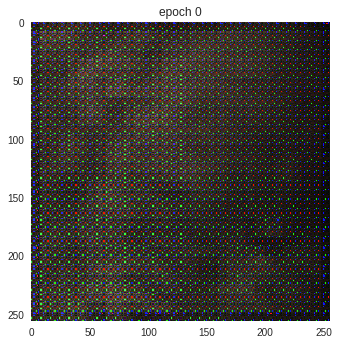


  1%|          | 1/100 [00:01<02:42,  1.64s/it]

epoch 1



  2%|▏         | 2/100 [00:02<02:24,  1.47s/it]

epoch 2



  3%|▎         | 3/100 [00:03<02:12,  1.37s/it]

epoch 3



  4%|▍         | 4/100 [00:04<02:04,  1.29s/it]

epoch 4



  5%|▌         | 5/100 [00:06<01:58,  1.24s/it]

epoch 5



  6%|▌         | 6/100 [00:07<01:53,  1.21s/it]

epoch 6



  7%|▋         | 7/100 [00:08<01:49,  1.18s/it]

epoch 7



  8%|▊         | 8/100 [00:09<01:47,  1.16s/it]

epoch 8



  9%|▉         | 9/100 [00:10<01:44,  1.15s/it]

epoch 9



 10%|█         | 10/100 [00:11<01:42,  1.14s/it]

epoch 10


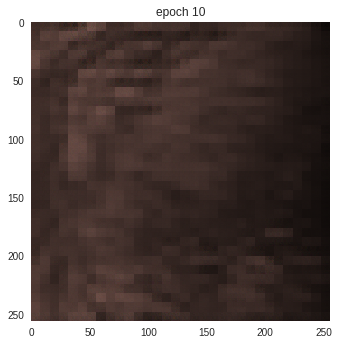


 11%|█         | 11/100 [00:13<01:54,  1.29s/it]

epoch 11



 12%|█▏        | 12/100 [00:14<01:46,  1.21s/it]

epoch 12



 13%|█▎        | 13/100 [00:15<01:43,  1.18s/it]

epoch 13



 14%|█▍        | 14/100 [00:16<01:40,  1.17s/it]

epoch 14



 15%|█▌        | 15/100 [00:17<01:38,  1.15s/it]

epoch 15



 16%|█▌        | 16/100 [00:18<01:36,  1.14s/it]

epoch 16



 17%|█▋        | 17/100 [00:19<01:34,  1.14s/it]

epoch 17



 18%|█▊        | 18/100 [00:21<01:33,  1.13s/it]

epoch 18



 19%|█▉        | 19/100 [00:22<01:31,  1.13s/it]

epoch 19



 20%|██        | 20/100 [00:23<01:30,  1.13s/it]

epoch 20


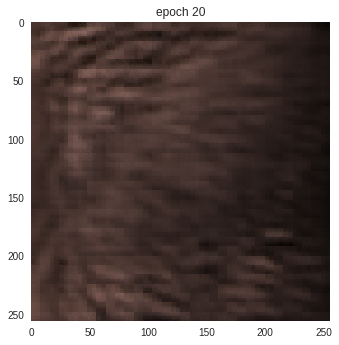


 21%|██        | 21/100 [00:24<01:40,  1.28s/it]

epoch 21



 22%|██▏       | 22/100 [00:26<01:33,  1.20s/it]

epoch 22



 23%|██▎       | 23/100 [00:27<01:30,  1.18s/it]

epoch 23



 24%|██▍       | 24/100 [00:28<01:28,  1.16s/it]

epoch 24



 25%|██▌       | 25/100 [00:29<01:26,  1.15s/it]

epoch 25



 26%|██▌       | 26/100 [00:30<01:24,  1.14s/it]

epoch 26



 27%|██▋       | 27/100 [00:31<01:23,  1.14s/it]

epoch 27



 28%|██▊       | 28/100 [00:32<01:21,  1.13s/it]

epoch 28



 29%|██▉       | 29/100 [00:33<01:20,  1.13s/it]

epoch 29



 30%|███       | 30/100 [00:34<01:18,  1.13s/it]

epoch 30


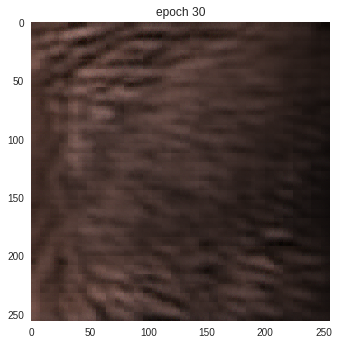


 31%|███       | 31/100 [00:36<01:30,  1.31s/it]

epoch 31



 32%|███▏      | 32/100 [00:37<01:23,  1.23s/it]

epoch 32



 33%|███▎      | 33/100 [00:38<01:20,  1.20s/it]

epoch 33



 34%|███▍      | 34/100 [00:40<01:17,  1.17s/it]

epoch 34



 35%|███▌      | 35/100 [00:41<01:15,  1.16s/it]

epoch 35



 36%|███▌      | 36/100 [00:42<01:13,  1.15s/it]

epoch 36



 37%|███▋      | 37/100 [00:43<01:11,  1.14s/it]

epoch 37



 38%|███▊      | 38/100 [00:44<01:10,  1.14s/it]

epoch 38



 39%|███▉      | 39/100 [00:45<01:09,  1.13s/it]

epoch 39



 40%|████      | 40/100 [00:46<01:07,  1.13s/it]

epoch 40


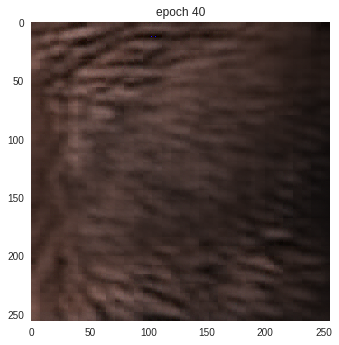


 41%|████      | 41/100 [00:48<01:15,  1.28s/it]

epoch 41



 42%|████▏     | 42/100 [00:49<01:09,  1.20s/it]

epoch 42



 43%|████▎     | 43/100 [00:50<01:07,  1.18s/it]

epoch 43



 44%|████▍     | 44/100 [00:51<01:05,  1.16s/it]

epoch 44



 45%|████▌     | 45/100 [00:52<01:03,  1.15s/it]

epoch 45



 46%|████▌     | 46/100 [00:53<01:01,  1.14s/it]

epoch 46



 47%|████▋     | 47/100 [00:55<01:00,  1.14s/it]

epoch 47



 48%|████▊     | 48/100 [00:56<00:58,  1.13s/it]

epoch 48



 49%|████▉     | 49/100 [00:57<00:57,  1.13s/it]

epoch 49



 50%|█████     | 50/100 [00:58<00:56,  1.13s/it]

epoch 50


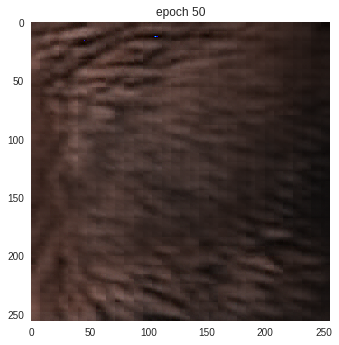


 51%|█████     | 51/100 [01:00<01:02,  1.28s/it]

epoch 51



 52%|█████▏    | 52/100 [01:01<00:57,  1.20s/it]

epoch 52



 53%|█████▎    | 53/100 [01:02<00:55,  1.18s/it]

epoch 53



 54%|█████▍    | 54/100 [01:03<00:53,  1.16s/it]

epoch 54



 55%|█████▌    | 55/100 [01:04<00:51,  1.15s/it]

epoch 55



 56%|█████▌    | 56/100 [01:05<00:50,  1.14s/it]

epoch 56



 57%|█████▋    | 57/100 [01:06<00:48,  1.14s/it]

epoch 57



 58%|█████▊    | 58/100 [01:07<00:47,  1.13s/it]

epoch 58



 59%|█████▉    | 59/100 [01:08<00:46,  1.13s/it]

epoch 59



 60%|██████    | 60/100 [01:10<00:45,  1.13s/it]

epoch 60


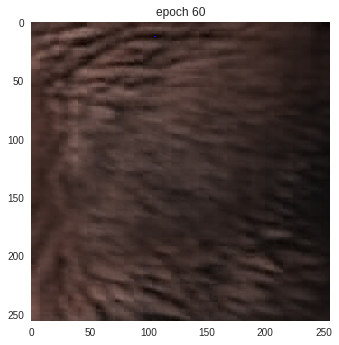


 61%|██████    | 61/100 [01:11<00:49,  1.28s/it]

epoch 61



 62%|██████▏   | 62/100 [01:12<00:45,  1.20s/it]

epoch 62



 63%|██████▎   | 63/100 [01:13<00:43,  1.18s/it]

epoch 63



 64%|██████▍   | 64/100 [01:14<00:41,  1.16s/it]

epoch 64



 65%|██████▌   | 65/100 [01:16<00:40,  1.15s/it]

epoch 65



 66%|██████▌   | 66/100 [01:17<00:38,  1.14s/it]

epoch 66



 67%|██████▋   | 67/100 [01:18<00:37,  1.14s/it]

epoch 67



 68%|██████▊   | 68/100 [01:19<00:36,  1.13s/it]

epoch 68



 69%|██████▉   | 69/100 [01:20<00:35,  1.13s/it]

epoch 69



 70%|███████   | 70/100 [01:21<00:33,  1.13s/it]

epoch 70


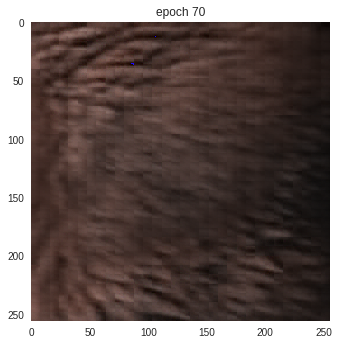


 71%|███████   | 71/100 [01:23<00:37,  1.28s/it]

epoch 71



 72%|███████▏  | 72/100 [01:24<00:33,  1.21s/it]

epoch 72



 73%|███████▎  | 73/100 [01:25<00:31,  1.18s/it]

epoch 73



 74%|███████▍  | 74/100 [01:26<00:30,  1.16s/it]

epoch 74



 75%|███████▌  | 75/100 [01:27<00:28,  1.15s/it]

epoch 75



 76%|███████▌  | 76/100 [01:28<00:27,  1.14s/it]

epoch 76



 77%|███████▋  | 77/100 [01:29<00:26,  1.14s/it]

epoch 77



 78%|███████▊  | 78/100 [01:31<00:24,  1.13s/it]

epoch 78



 79%|███████▉  | 79/100 [01:32<00:23,  1.13s/it]

epoch 79



 80%|████████  | 80/100 [01:33<00:22,  1.13s/it]

epoch 80


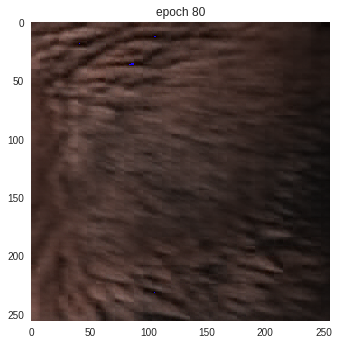


 81%|████████  | 81/100 [01:34<00:24,  1.28s/it]

epoch 81



 82%|████████▏ | 82/100 [01:35<00:21,  1.20s/it]

epoch 82



 83%|████████▎ | 83/100 [01:37<00:20,  1.18s/it]

epoch 83



 84%|████████▍ | 84/100 [01:38<00:18,  1.16s/it]

epoch 84



 85%|████████▌ | 85/100 [01:39<00:17,  1.15s/it]

epoch 85



 86%|████████▌ | 86/100 [01:40<00:15,  1.14s/it]

epoch 86



 87%|████████▋ | 87/100 [01:41<00:14,  1.14s/it]

epoch 87



 88%|████████▊ | 88/100 [01:42<00:13,  1.13s/it]

epoch 88



 89%|████████▉ | 89/100 [01:43<00:12,  1.13s/it]

epoch 89



 90%|█████████ | 90/100 [01:44<00:11,  1.13s/it]

epoch 90


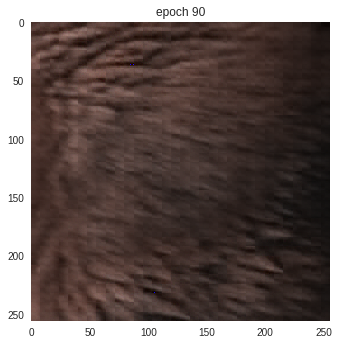


 91%|█████████ | 91/100 [01:46<00:11,  1.27s/it]

epoch 91



 92%|█████████▏| 92/100 [01:47<00:09,  1.20s/it]

epoch 92



 93%|█████████▎| 93/100 [01:48<00:08,  1.18s/it]

epoch 93



 94%|█████████▍| 94/100 [01:49<00:06,  1.16s/it]

epoch 94



 95%|█████████▌| 95/100 [01:51<00:05,  1.15s/it]

epoch 95



 96%|█████████▌| 96/100 [01:52<00:04,  1.14s/it]

epoch 96



 97%|█████████▋| 97/100 [01:53<00:03,  1.14s/it]

epoch 97



 98%|█████████▊| 98/100 [01:54<00:02,  1.13s/it]

epoch 98



 99%|█████████▉| 99/100 [01:55<00:01,  1.13s/it]

epoch 99



100%|██████████| 100/100 [01:56<00:00,  1.13s/it]


In [31]:
model = SimpleCNN3D()
model.cuda()
optimizer = torch.optim.Adam(model.parameters())
eps = 100

freq = 10

losses = []

for ep in tqdm(range(eps)):
  
  print('epoch {}'.format(ep))
  
  for seq,y in get_seq(fold, 6):
    
    seq = seq.cuda()
    y = y.cuda()
    
    optimizer.zero_grad()
    
    pred = model(seq)
    
    loss = torch.norm(y - pred)
    losses += [loss]
    loss.backward()
    
    optimizer.step()
  
  if ep%freq == 0:
  
    plt.figure()
    plt.imshow(pred[0].transpose(2,0).detach().cpu().numpy().astype('uint8'))
    plt.title('epoch {}'.format(ep))
    plt.grid(False)  
    plt.show()
    



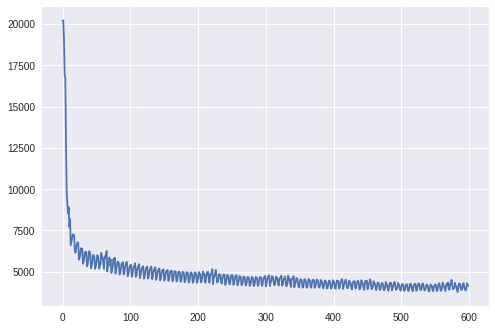

In [33]:
plt.plot(range(len(losses)), losses)